# Vignette 1: Introduction to NetworkCommons

Welcome to `NetworkCommons`! In this initial vignette, we will go through the basics of the package, using some methods to create contextualised subnetworks and finish with two evaluation settings. 

In this vignette, we will use a single contrast (Afatinib-treated vs DMSO-treated ASPC cells) from the [PANACEA](../datasets.html#panacea) dataset to contextualise a signalling network from [OmniPath](../datasets.html#omnipath). For this, we will:

1. Download the data from the server. In this case, the data has already been processed, using filtering + DESeq2 for differential expression analysis, coupled to TF activity estimation using Decoupler-py and CollecTRI

3. Contextualise the network signalling network, using EGFR as perturbation (inhibited by Afatinib) and TFs as measurements, using several causal and topological methodologies.

4. Visualise the networks.

First, we need to import the packages that we're going to use in this notebook

In [1]:
import networkcommons as nc
import pandas as pd
import decoupler as dc
import corneto as cn
from IPython.display import HTML, display

## 1. Processing of transcriptomics data

We can see the available datasets, along with some information about them, using the ``nc.data.omics.datasets`` util function. For more information about the data itself, check the [Datasets details page](../datasets.html).

In [3]:
nc.data.omics.datasets()

,name,description,publication_link,detailed_description
decryptm,DecryptM,Drug perturbation proteomics and phosphoproteomics data,https://doi.org/10.1126/science.ade3925,"This dataset contains the profiling of 31 cancer drugs in 13 human cancer cell line models resulted in 1.8 million dose-response curves, including 47,502 regulated phosphopeptides, 7316 ubiquitinylated peptides, and 546 regulated acetylated peptides."
panacea,Panacea,Pancancer Analysis of Chemical Entity Activity RNA-Seq data,https://doi.org/10.1016/j.xcrm.2021.100492,"PANACEA contains dose-response and perturbational profiles for 32 kinase inhibitors in 11 cancer cell lines, in addition to a DMSO control. Originally, this resource served as the basis for a DREAM Challenge assessing the accuracy and sensitivity of computational algorithms for de novo drug polypharmacology predictions."
CPTAC,CPTAC,Clinical Proteomic Tumor Analysis Consortium data,https://doi.org/10.1158/2159-8290.CD-13-0219,This dataset contains data from the Clinical Proteomic Tumor Analysis Consortium. It includes various cancer types and proteomic data.
NCI60,NCI60,NCI-60 cell line data,https://doi.org/10.1038/nrc1951,"This dataset contains data from the NCI-60 cell line panel. It includes three files: TF activities from transcriptomics data, metabolite abundances and gene reads."


For this vignette, we will use the PANACEA dataset:

> Eugene F. Douglass et al., A community challenge for a pancancer drug mechanism of action inference from perturbational profile data. *Cell Reports Medicine (2022)*. https://doi.org/10.1016/j.xcrm.2021.100492.

PANACEA is a collection of perturbational transcriptomics profiles of 32 drugs and 11 cell lines.
Users can retrieve a raw count matrix and metadata associated, but they can also get differential expression estimates directly from the server. For the sake of simplicity, we will do the latter. 

In [12]:
de_results = nc.data.omics.panacea_tables(cell_line='ASPC', drug='AFATINIB', type='diffexp').set_index('ID')

In [13]:
de_results.head()

,logFC,padj,stat
ID,,,
A1BG,NaN,NaN,NaN
A1BG-AS1,NaN,NaN,NaN
A1CF,-0.344588,0.728672,-0.79661
A2M,NaN,NaN,NaN
A2M-AS1,NaN,NaN,NaN


We can visualise these results in a volcano plot:

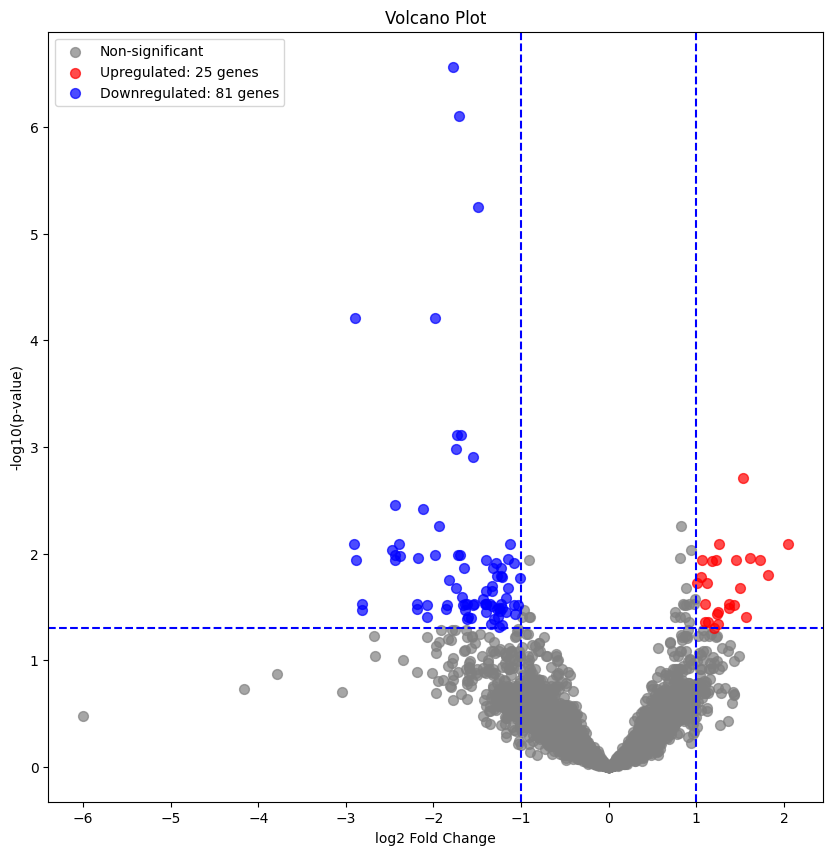

In [14]:
nc.visual.build_volcano_plot(de_results, 'logFC', 'padj')

Next, we will perform TF activity estimation with ``decoupler``. In this vignette we will focus on the signalling network from network, thus our measurement layer will be at the TF level. ``NetworkCommons`` contains a util function to prepare diffexp output to be used with ``decoupler``. 
We retrieve then the CollecTRI TF gene sets via ``decoupler`` and perform the enrichment analysis using univariate linear model (ulm)

In [15]:
decoupler_input = nc.utils.decoupler_formatter(de_results, 'stat')
collectri_net = dc.get_collectri()
dc_estimates, dc_pvals = dc.run_ulm(decoupler_input, collectri_net)

In [16]:
measurements = nc.utils.targetlayer_formatter(dc_estimates.T)

## 2. Network inference

We have now our set of TF measurements, which we will use as footprints of the perturbation induced by Afatinib. We will use these to contextualised a general PPI network retrieved from OmniPath.

In [ ]:
network = nc.data.network.get_omnipath()
graph = nc.utils.network_from_df(network)

Afatinib targets EGFR by inhibition, so we will create a source dictionary containing the origin of perturbation, EGFR, and the sign of the perturbation (negative, therefore -1).

In [ ]:
source_df = pd.DataFrame({'source': ['EGFR'], 
                          'sign': [-1]}, columns=['source', 'sign'])
source_df.set_index('source', inplace=True)
sources = source_df['sign'].to_dict()

### 2.1 CORNETO

<div class="alert alert-warning">

**Warning**
    
This section of the tutorial uses CORNETO, a package specialised in Integer Linear programming for network inference. Some CORNETO methods (such as Carnival) depend on GUROBI, a third-party solver that holds a commercial license. Therefore, in order to run this part of the code, you will have to install a license in your system. Please check their home page for more information. 

</div>

In [ ]:
corneto_graph = nc.methods.to_cornetograph(graph)

In [ ]:
corneto_network = nc.methods.run_corneto_carnival(corneto_graph, sources, measurements, betaWeight=0.01, solver='GUROBI')

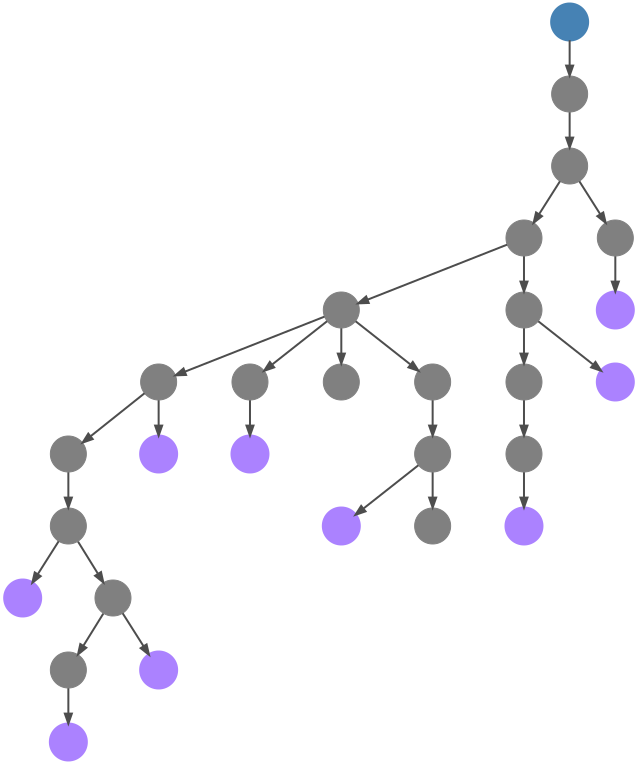

In [ ]:
a = nc.visual.visualize_graph_simple(corneto_network, sources, measurements, is_sign_consistent=False)
style = "<style>svg{width:25% !important;height:25% !important;</style>"
display(HTML(style))
display(a)

### 2.2 Topological methods: shortest paths, all paths, sign consistency, Personalised PageRank

NetworkCommons also includes several topological methods. These methods follow very simple assumptions, and therefore are well suited to be compared against more advanced methodologies.

**Shortest paths**

This method retrieves the shortest path between source and target nodes. In the case where there are many paths with the same length, all these paths will be retrieved.

In [ ]:
shortest_path_network, shortest_paths_list = nc.methods.run_shortest_paths(graph, sources, measurements)

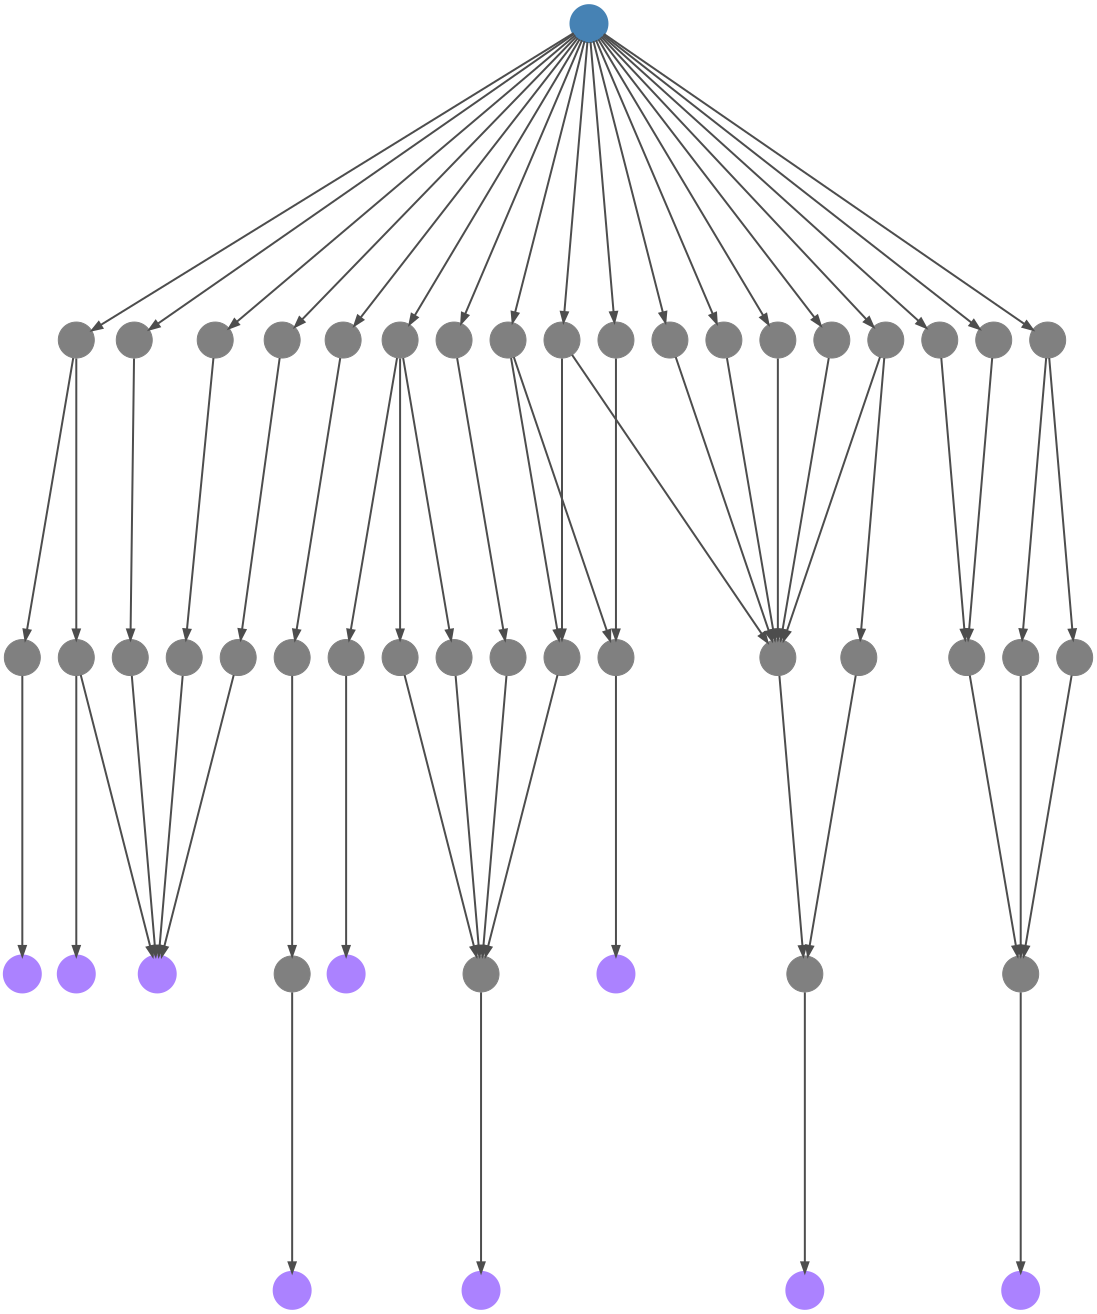

In [ ]:
a = nc.visual.visualize_graph_simple(shortest_path_network, sources, measurements, is_sign_consistent=False)
style = "<style>svg{width:25% !important;height:25% !important;</style>"
display(HTML(style))
display(a)

We can use the signs of the network to add an additional layer of constrain to the problem by removing the paths which are not coherent in terms of sign. The algorithm computes an overall sign of the path by multiplying the signs of the edges contained in said path, and then evaluates whether perturbation_sign * path_sign = measurement_sign. If it does not, the path is discarded.

In [ ]:
shortest_sc_network, shortest_sc_list = nc.methods.run_sign_consistency(shortest_path_network, shortest_paths_list, sources, measurements)

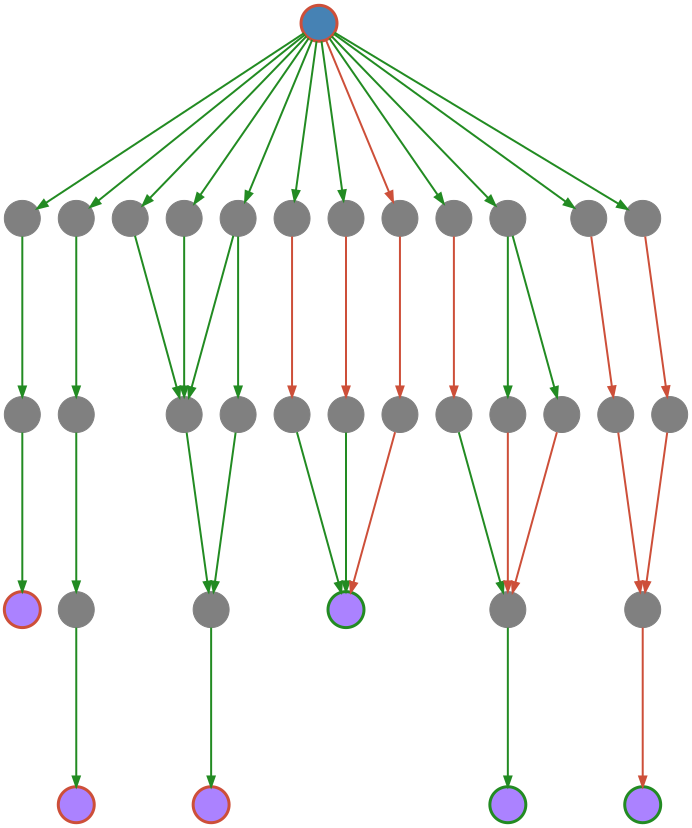

In [ ]:
a = nc.visual.visualize_graph_simple(shortest_sc_network, sources, measurements, is_sign_consistent=True)
style = "<style>svg{width:25% !important;height:25% !important;</style>"
display(HTML(style))
display(a)

We used the measurements to select which paths we keep and which paths don't make sense, given our observed measurements. For cases in which we don't have a sign of a measurement, we can infer the signs by evaluating the agreement of the paths on the sign of the downstream measurement. For this, we must not provide the `run_sign_consistency()` function with a target dictionary. It will then infer the signs of the downstream layer and then return the dictionary with the inferred signs.

In [ ]:
shortest_sc_network_inferred, shortest_sc_list_inferred, inferred_signs = nc.methods.run_sign_consistency(shortest_path_network, shortest_paths_list, sources)

No target sign provided. Inferring target signs by majority consensus.


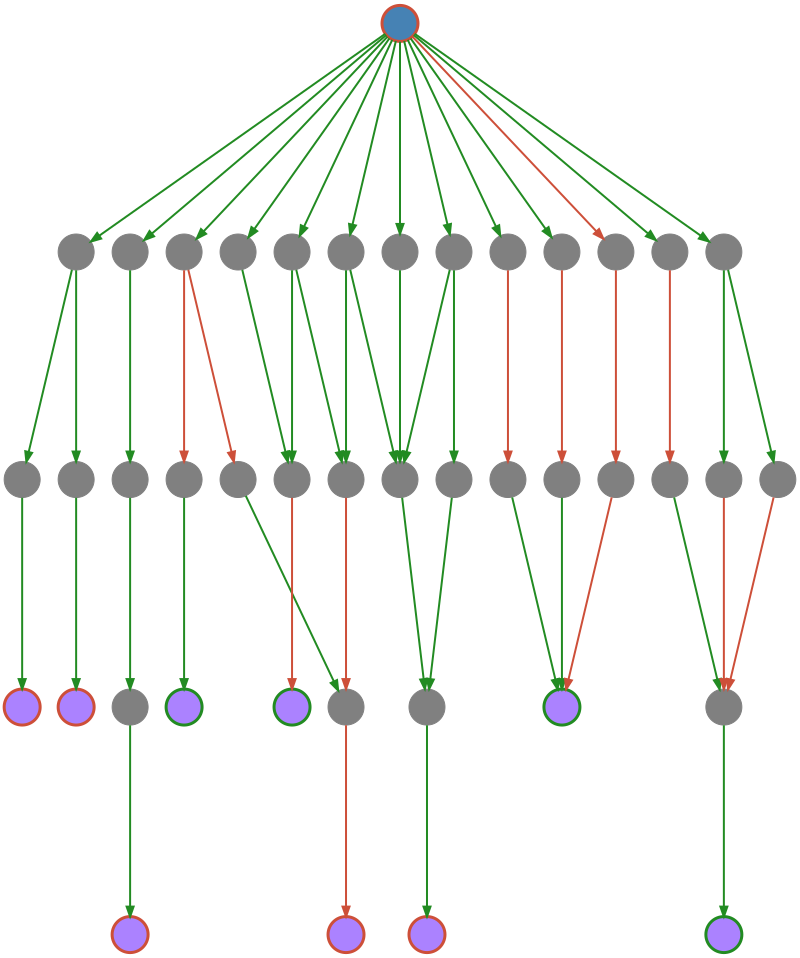

In [ ]:
a = nc.visual.visualize_graph_simple(shortest_sc_network_inferred, sources, inferred_signs, is_sign_consistent=True)
style = "<style>svg{width:25% !important;height:25% !important;</style>"
display(HTML(style))
display(a)

**All paths**

As an alternative method, we can retrieve all possible paths (within a limit, due to computational constrains) between source and measurements layers. This might help us capture additional biological information which might not be available when considering more restrictive methods, such as shortest paths.

In [ ]:
all_paths_network, all_paths_list = nc.methods.run_all_paths(graph, sources, measurements, depth_cutoff=4)

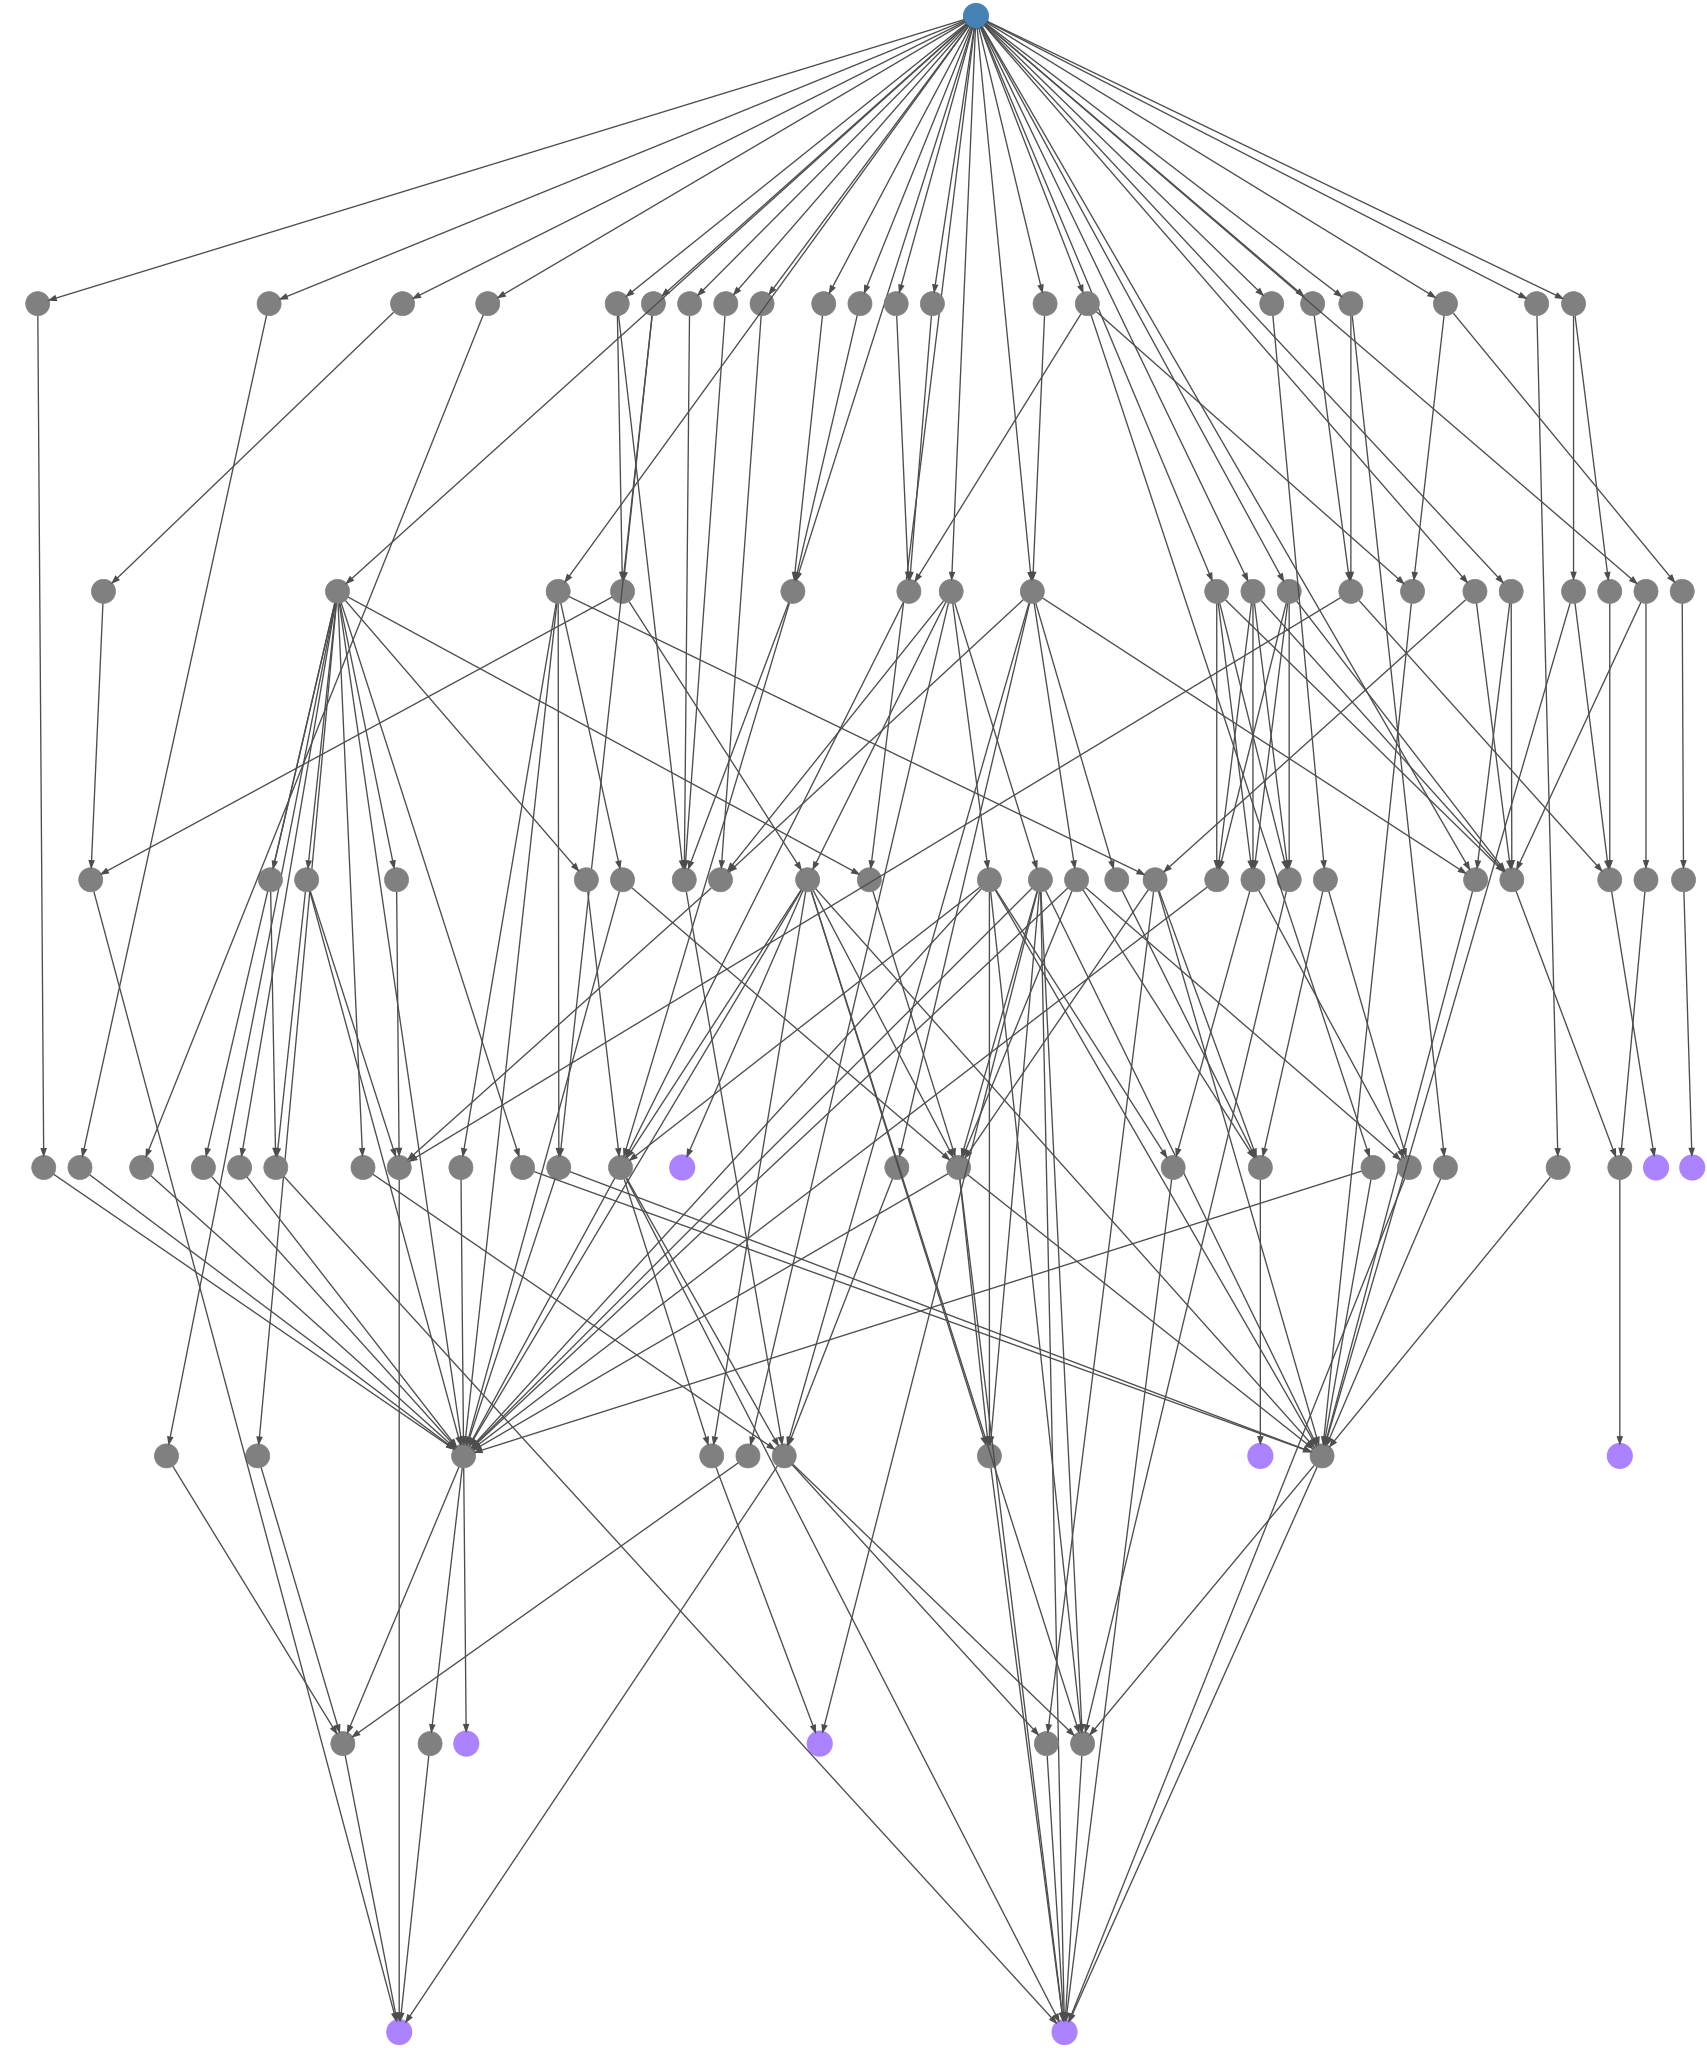

In [ ]:
a = nc.visual.visualize_graph_simple(all_paths_network, sources, measurements, is_sign_consistent=False)
style = "<style>svg{width:25% !important;height:25% !important;</style>"
display(HTML(style))
display(a)

Like in the previous case, we can apply an additional constrain by removing non-coherent paths in terms of signed interactions.

In [ ]:
allpaths_sc_network, allpaths_sc_list = nc.methods.run_sign_consistency(all_paths_network, all_paths_list, sources, measurements)

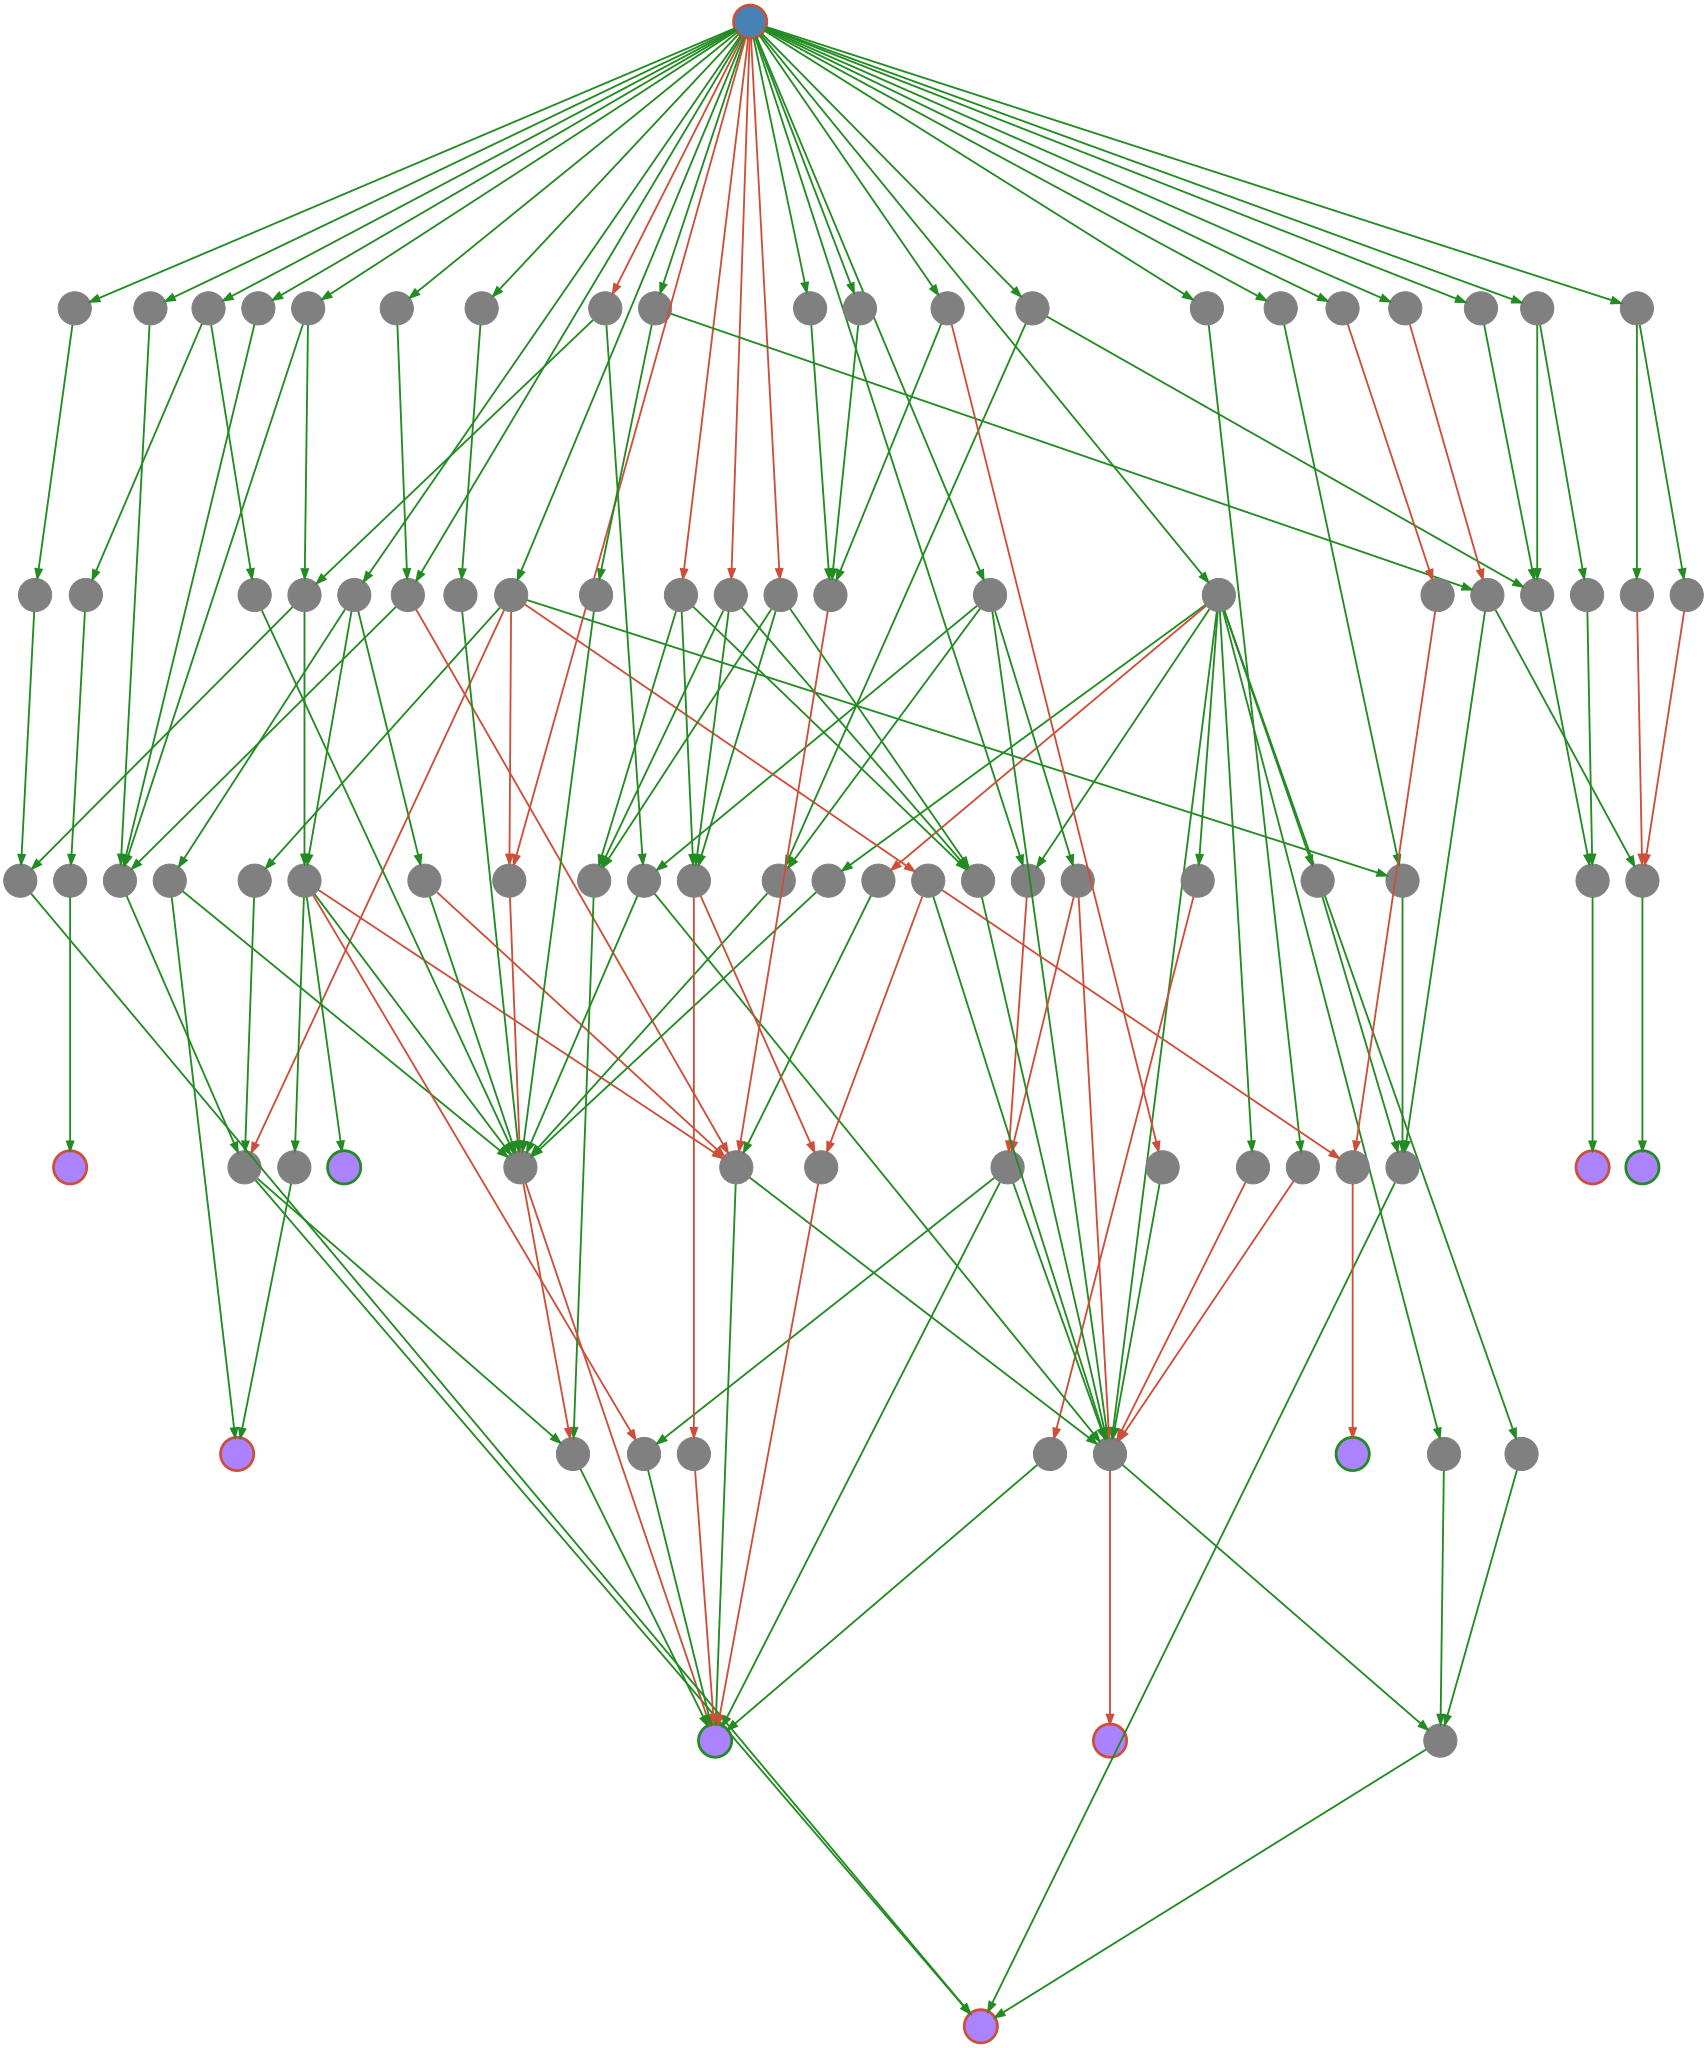

In [ ]:
a = nc.visual.visualize_graph_simple(allpaths_sc_network, sources, measurements, is_sign_consistent=True)
style = "<style>svg{width:25% !important;height:25% !important;</style>"
display(HTML(style))
display(a)

**Personalised PageRank**

Several other methods follow a heat diffusion philosophy: "heat" propagates using the network topology and the "hottest" nodes are in the perturbation/measurement layers, cooling down the further away from these layers a node is.
In our approach, we use personalised PageRank (PPR), in which the probabilities of the random walker are altered, as a computationally inexpensive approach to this philosophy.
We compute PPR values starting from both perturbation and measurement layers, and then by applying a threshold (top % nodes with highest PPR value) we retrieve only the network which is most accessible from these two layers.

In [ ]:
ppr_network = nc.methods.add_pagerank_scores(graph, sources, measurements, personalize_for='source')
ppr_network = nc.methods.add_pagerank_scores(ppr_network, sources, measurements, personalize_for='target')

ppr_network = nc.methods.compute_ppr_overlap(ppr_network, percentage=1)

Now, we can use a path-recover method, such as shortest paths or all paths, to retrieve a smaller subnetwork.

In [ ]:
shortest_ppr_network, shortest_ppr_list = nc.methods.run_shortest_paths(ppr_network, sources, measurements)

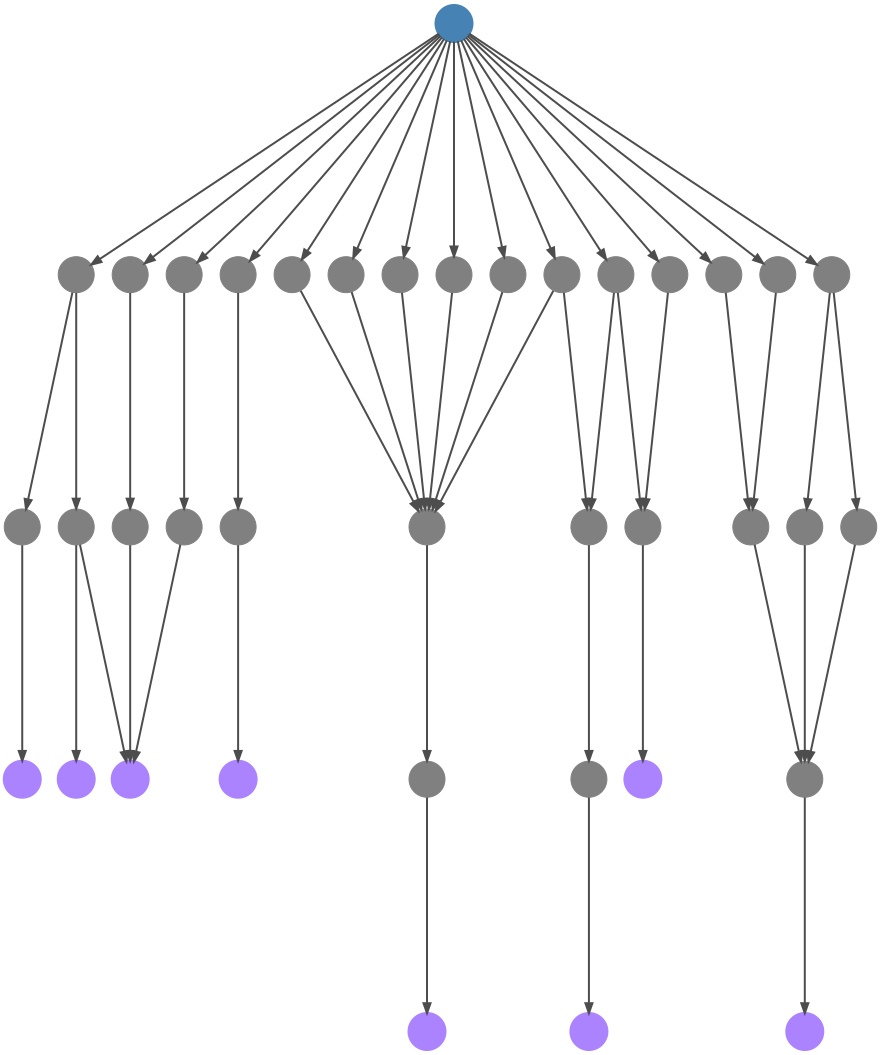

In [ ]:
a = nc.visual.visualize_graph_simple(shortest_ppr_network, sources, measurements, is_sign_consistent=False)
style = "<style>svg{width:25% !important;height:25% !important;</style>"
display(HTML(style))
display(a)

We can also add sign consistency checks:

In [ ]:
shortest_sc_ppr_network, shortest_sc_ppr_list = nc.methods.run_sign_consistency(shortest_ppr_network, shortest_ppr_list, sources, measurements)

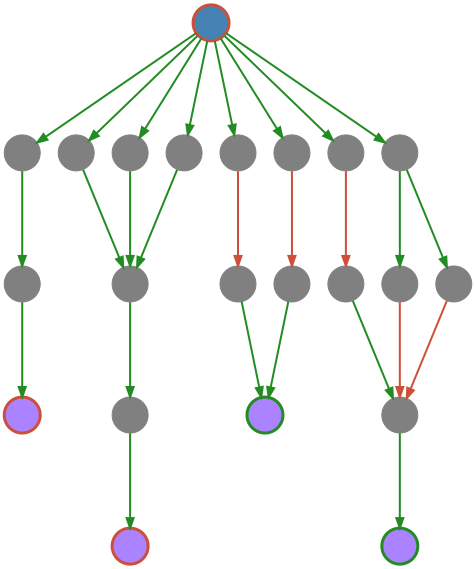

In [ ]:
a = nc.visual.visualize_graph_simple(shortest_sc_ppr_network, sources, measurements, is_sign_consistent=True)
style = "<style>svg{width:25% !important;height:25% !important;</style>"
display(HTML(style))
display(a)

## 3. Description

Now that we have the networks inferred using different approaches, we can compare them in terms of size, connectivity or centrality. For this, ``NetworkCommons`` incorporates several functions to retrieve this code:

In [ ]:
# we include all the networks in a dictionary with custom labels
networks = {
    'shortest_path': shortest_path_network,
    'shortest_path_sc': shortest_sc_network,
    'all_paths': all_paths_network,
    'all_paths_sc': allpaths_sc_network,
    'shortest_ppr_network': shortest_ppr_network,
    'shortest_ppr_sc_network': shortest_sc_ppr_network,
    'corneto': corneto_network
}

In [ ]:
metrics = nc.eval.get_graph_metrics(networks, measurements)

Now, we can have a look at different topological metrics. For example, we see that networks inferred with the *all paths* method tend to have bigger networks, while Corneto/Carnival and shortest path + sign consistency show the lowest values. 

## 4. Evaluation strategy using pathway recovery

Finally, a question remains: how do these networks perform? We will follow here a very intuitive approach: if a network contextualises properly a given perturbation, a large share of members of the perturbed pathway will appear in the solution network. Therefore, we will perform Overrepresentation analysis between the members of these networks, and a gene set from [Biocarta](https://www.gsea-msigdb.org/gsea/msigdb/cards/BIOCARTA_EGF_PATHWAY) containing the members of the EGF canonical pathway. If the network contextualises properly, the affected pathway(s) will have a higher ORA score (they will be ranked higher than other pathways).

First, we neet the pathway signatures from BioCarta, which are available in the MSigDB database

In [ ]:
signatures = dc.get_resource('MSigDB', organism='human')
biocarta_elements = signatures[signatures['collection'] == 'biocarta_pathways']
biocarta_elements.rename(columns={'geneset': 'source', 'genesymbol': 'target'}, inplace=True)
biocarta_elements.drop_duplicates(inplace=True)

In [ ]:
ora_results = nc.eval.get_metric_from_networks(networks, 'run_ora', net=biocarta_elements)

In [ ]:
ora_results.head()

,ora_Term,ora_Set size,ora_Overlap ratio,ora_p-value,ora_FDR p-value,ora_Odds ratio,ora_Combined score,ora_Features,ora_rank,network
0,BIOCARTA_ACH_PATHWAY,14,0.214286,4.935893e-06,1.154240e-05,103.748980,1267.706398,AKT1;FOXO3;PIK3R1,55.0,shortest_path
1,BIOCARTA_ACTINY_PATHWAY,12,0.083333,2.901493e-02,3.366617e-02,49.456082,175.071808,RAC1,129.0,shortest_path
2,BIOCARTA_AGR_PATHWAY,33,0.151515,1.612945e-08,6.451779e-08,73.668455,1321.805047,CDC42;EGFR;MAPK1;MAPK3;RAC1,52.0,shortest_path
3,BIOCARTA_AKAP95_PATHWAY,11,0.090909,2.662885e-02,3.137663e-02,53.759301,194.918318,CDK1,125.0,shortest_path
4,BIOCARTA_AKAPCENTROSOME_PATHWAY,14,0.071429,3.376989e-02,3.802240e-02,42.630288,144.439329,CDK1,133.0,shortest_path


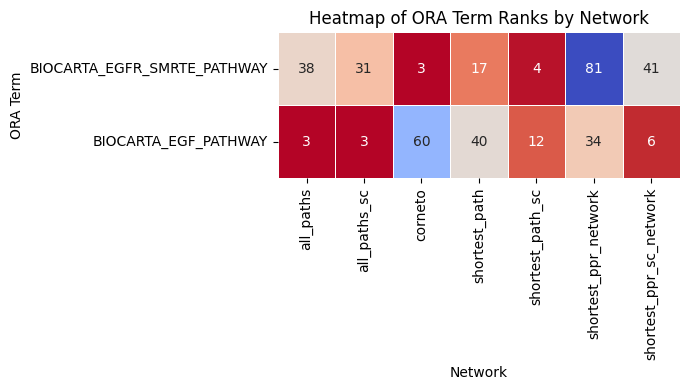

In [ ]:
nc.visual.create_rank_heatmap(ora_results, ['BIOCARTA_EGF_PATHWAY', 'BIOCARTA_EGFR_SMRTE_PATHWAY'])

We see that, for the first pathway, BIOCARTA_EGFR_SMRTE_PATHWAY, the CORNETO causal approach scores the highest, followed by the network using shortest paths and sign consistency. For the second, though, approaches using all paths score the highest, followed by shortest paths + PageRank + sign consistency.
Given that CORNETO network is smaller than the other competitors, we would consider it to be the best performer. 

<div class="alert alert-block alert-info">

<b>⚠️</b> This approach has the flaw of favouring bigger sizes, since there will be a bigger overlap with other pathways if the network is bigger. This evaluation setting is still under development.

</div>

Thank you for trying **NetworkCommons**! We hope you found this tutorial helpful. We showcased data imports, methods, visualization and metric extraction features that are already implemented. 
However, this is just the beginning! We aim to expand this collection of tools and methods by incorporating more data sources, methods, and visualizations.
If you have any questions or feedback, or you would like to contribute, please feel free to reach out to us :)